<a href="https://colab.research.google.com/github/willychangx/covid-ml/blob/main/eg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download folders. You don't need to change anything, you'll be downloading from my Google Drive.

%%capture

# Others.zip
!gdown https://drive.google.com/uc?id=1L9dHYx2EwywfH3bWAcWPSDRCy-VsA8mX
!unzip /content/Others.zip -d /content

# Healthy.zip
!gdown https://drive.google.com/uc?id=1FQMhrVAvzBp38bMDpXnRbJZ6ghnNEKBb
!unzip /content/Healthy.zip -d /content

# Covid.zip
!gdown https://drive.google.com/uc?id=1CHCjoLEcf4imlgxp2EEphZKmiyTV6-vQ
!unzip /content/Covid.zip -d /content
%cd /content

In [2]:
# Import libraries for the training
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import torchvision.models as models
from PIL import Image

import os
import cv2
import shutil
import math
import random

In [3]:
# Parameters for the training
params = {
    "batch": 10, # batch size (samples per epoch)
    "child": 5, # [0, 10), number of layers of resnet to freeze
    "childchild": 3, # number of child_child to freeze
    "lr": 1e-3, # learning rate 
    "wd": 0.01, # weight decay
    "epochs": 32, # number of epochs (iterations)
    "percent": 0.20, # % of the dataset to split up (1/percent = # of folds for cross validation)
    "size": 224,
}

In [4]:
# Declare the types of classification
types = ['Covid', 'Others', 'Healthy']
newFolderPath = []

# Input: Single folder name
# Output: Combine all images in subfolders into one folder called ./new_{patientType}
def combine_images(patientType):
    origDir = os.getcwd()
    currDir = origDir + '/' + patientType
    newFolder = origDir + '/new_' + patientType
    newFolderPath.append(newFolder)

    # If the folder to be created exists, delete and create a new one
    if os.path.isdir(newFolder):
        shutil.rmtree(newFolder)
    os.mkdir(newFolder)
    index = 0

    # Start going through each folder to extract image and paste into a new folder
    for folder in os.listdir(currDir):
        if os.path.isdir(currDir + '/' + folder):
            for filename in os.listdir(currDir + '/' + folder):
                if filename.endswith(".png"):
                    img = cv2.imread(currDir + '/' + folder + '/' + filename)
                    img = cv2.resize(img, (params["size"], params["size"]), interpolation=cv2.INTER_CUBIC)
                    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    cv2.imwrite(newFolder + '/' + str(index) + '.png', img)
                    index += 1
                    # Rotate images by 90, 180, 270 to increase the dataset
                    for x in range(3):
                        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                        cv2.imwrite(newFolder + '/' + str(index) + '.png', img)
                        index += 1
    # In case you already have the folders and don't want to go through everything
    # if patientType == 'Covid':
    #     index = 8668
    # elif patientType == 'Others':
    #     index = 4988
    # else:
    #     index = 3028
    
    print(f"Folder {patientType}: {index} files")

# For each classification folder, combine all images into a new folder    
for name in types:
    combine_images(name)

Folder Covid: 8668 files
Folder Others: 4988 files
Folder Healthy: 3028 files


In [5]:
# Input: An array of paths to the new folders
# Output: 5 new folders with 20% of the dataset each
def cross_validation_segments(paths) -> list:
    # Check if folders exist; Delete and make new if they do
    currDir = os.getcwd()
    randList = []
    for i in range(5):
        if os.path.isdir('Rand' + str(i)):
            shutil.rmtree('Rand' + str(i))
        os.mkdir('Rand' + str(i))
        randList.append(currDir + '/Rand' + str(i))

    arrIdx = [0 for i in range((int)(1/params["percent"]))]
    idx = 0
    arr = []
    id = 0

    # Create an array of all images and paths
    for path in paths:
        arr = [path + '/' + folder for folder in os.listdir(path)]
        # While there are still elements in the array
        while len(arr):
            # Randomly choose an image and place them into a folder
            val = random.randrange(len(arr))
            shutil.copyfile(arr[val], './Rand' + str(idx) + '/' + str(id) + '_' + str(arrIdx[idx]) + '.png')
            del arr[val]
            arrIdx[idx] += 1
            idx += 1
            idx %= 5
        id += 1
    return randList

randFolders = cross_validation_segments(newFolderPath)

In [6]:
def get_full_dataset(paths):
    if os.path.isdir('./All'):
        shutil.rmtree('./All')
    os.mkdir('All')
    idx = 0
    for path in paths:
        for folder in os.listdir(path):
            shutil.copyfile(path + '/' + folder, './All/' + str(idx) + '.png')
            idx += 1

get_full_dataset(newFolderPath)

mean = 0
var = 0
for file in os.listdir('./All'):
    img = cv2.imread('All/' + file, cv2.IMREAD_GRAYSCALE)
    mean += np.mean(img)
    var += np.var(img)
mean = mean / len(os.listdir('./All')) / 255
var = math.sqrt(var / len(os.listdir('./All'))) /255
print(f"Mean: {mean}, Variance: {var}")

Mean: 0.6534761057009093, Variance: 0.26040787855103414


In [7]:
# Input: Path
# Output: Array of images in path
def read_images(path) -> list:
    images = [im for im in os.listdir(path)]
    images.sort()
    ret = [cv2.imread(path + '/' + i, cv2.IMREAD_UNCHANGED) for i in images]
    return ret

# Input: Path
# Output: Array of numbers (labels)
def read_labels(path) -> list:
    labels = []
    store = []
    temp = [l for l in os.listdir(path)]
    temp.sort()
    for i, lbl in enumerate(temp):
        num = open(path + '/' + lbl, "r").read()
        if not num.isdigit():
            store.append(i)
        labels.append(num)
    return labels, store

# DataSet class to override some Dataset methods (functions)
class DataSet(Dataset):
    
    def __init__(self, root, iteration, randFolders, transform=None):
        idx = 0
        currDir = os.getcwd()
        train = False

        # Create the ./Dataset/{Train/Test}/{image/label} folders
        folderNames = root.split('/')
        for name in folderNames:
            if name != '.' and name != '':
                try:
                    os.mkdir(name)
                    os.chdir(name)
                except:
                    os.chdir(name)
            if name == 'Train':
                train = True
        
        os.mkdir('image')
        os.mkdir('label')

        # If it's not the training folder, use only one Rand folder
        if not train:
            for file in os.listdir(randFolders[iteration]):
                id = file.split('_')[0]
                if id != '':
                    shutil.copy2(randFolders[iteration] + '/' + str(file), './image/' + str(idx).zfill(5) + '.png')
                    fp = open("./label/" + str(idx).zfill(5) + '.txt', 'w')
                    fp.write(id)
                    idx += 1
        # Otherwise, use the other folders
        else:
            for num, folder in enumerate(randFolders):
                if num != iteration:
                    for file in os.listdir(folder):
                        id = file.split('_')[0]
                        if id != '':
                            shutil.copy2(folder + '/' + str(file), './image/' + str(idx).zfill(5) + '.png')
                            fp = open("./label/" + str(idx).zfill(5) + '.txt', "w")
                            fp.write(id)
                            idx += 1
      
        os.chdir(currDir)

        lab, getRid = read_labels(root + "/label")
        imag = read_images(root + "/image")

        for i in getRid:
            del lab[i]
            del imag[i]

        self.transform = transform
        self.ROOT = root
        self.images = imag
        self.labels = lab
        
    def __len__(self):
        # Return number of points in the dataset

        return len(self.images)

    def __getitem__(self, idx):
        # Here we have to return the item requested by `idx`. The PyTorch DataLoader class will use this method to make an iterable for training/validation loop.

        img = Image.fromarray(self.images[idx])
        label = int(self.labels[idx])

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [8]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: [Transfer learning with pre-trained ResNet-50] 1) Define how many first layers of convolutoinal neural network (CNN) feature extractor in ResNet-50 to be "frozen" and 2) design your own fully-connected network (FCN) classifier.
        # 1) You will only refine last several layers of CNN feature extractor in ResNet-50 that mainly relate to high-level vision task. Determine how many first layers of ResNet-50 should be frozen to achieve best performances. Commented codes below will help you understand the architecture, i.e., "children", of ResNet-50.
        # 2) Design your own FCN classifier. Here I provide a sample of two-layer FCN.
        # Refer to PyTorch documentations of torch.nn to pick your layers. (https://pytorch.org/docs/stable/nn.html)
        # Some common Choices are: Linear, ReLU, Dropout, MaxPool2d, AvgPool2d
        # If you have many layers, consider using nn.Sequential() to simplify your code
        
        # Load pretrained ResNet-50
        self.model_resnet = models.resnet50(pretrained=True)
        
        # The code below can show children of ResNet-50
        # child_counter = 0
        # for child in self.model_resnet.children():
        #    print(" child", child_counter, "is -")
        #    print(child)
        #    child_counter += 1
        
        # TODO: Determine how many first layers of ResNet-50 to freeze
        child_counter = 0
        for child in self.model_resnet.children():
            if child_counter < params['child']:
                for param in child.parameters():
                    param.requires_grad = False
            elif child_counter == params['child']:
                children_of_child_counter = 0
                for children_of_child in child.children():
                    if children_of_child_counter < params['childchild']:
                        for param in children_of_child.parameters():
                            param.requires_grad = False
                    else:
                        children_of_child_counter += 1
            else:
                print("child ",child_counter," was not frozen")
            child_counter += 1
        
        # Set ResNet-50's FCN as an identity mapping
        num_fc_in = self.model_resnet.fc.in_features
        self.model_resnet.fc = nn.Identity()

        # TODO: Design your own FCN
        self.fc1 = nn.Linear(num_fc_in, 128, bias = False) # from input of size num_fc_in to output of size ?
        self.b1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 128, bias = False)
        self.b2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 3, bias = False)

    def forward(self,x):
        # TODO: Design your own network, implement forward pass here
        
        relu = nn.ReLU() # No need to define self.relu because it contains no parameters
        pool = nn.MaxPool2d(3)
        drop = nn.Dropout(p=0.2)

        # x = pool(x)

        with torch.no_grad():
            features = self.model_resnet(x)
        
        x = self.fc1(features) # Activation are flattened before being passed to the fully connected layers
        x = self.b1(x)
        x = relu(x)
        # x = drop(x)
        x = self.fc2(x)
        x = self.b2(x)
        x = relu(x)
        # x = drop(x)
        x = self.fc3(x)
        
        # The loss layer will be applied outside Network class
        return x

Running 0 fold...
Loading datasets...
Done!


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen
Start training...
Epoch 1 training loss:0.658711939770868
Epoch 1 testing loss:0.5830892530289499
Epoch 2 training loss:0.5367573891086378
Epoch 2 testing loss:0.5217346105579141
Epoch 3 training loss:0.5046742121162622
Epoch 3 testing loss:0.4995710761160464
Epoch 4 training loss:0.459330434607959
Epoch 4 testing loss:0.5063821781236488
Epoch 5 training loss:0.4493769847995963
Epoch 5 testing loss:0.5098076190452676
Epoch 6 training loss:0.4328971834856084
Epoch 6 testing loss:0.4967879770441098
Epoch 7 training loss:0.424898329401749
Epoch 7 testing loss:0.4821503274702095
Epoch 8 training loss:0.41082700280503354
Epoch 8 testing loss:0.46443843154667375
Epoch 9 training loss:0.4096796796719978
Epoch 9 testing loss:0.47312354137589624
Epoch 10 training loss:0.39536854499082513
Epoch 10 testing loss:0.48631444548790875
Epoch 11 training loss:0.3972381505964399
Epoch 11 testing loss:0.4

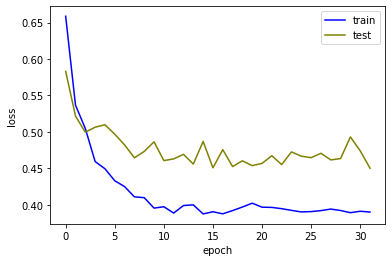

Evaluate on test set
Evaluation accuracy: 0.8663069544364509
Running 1 fold...
Loading datasets...
Done!
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen
Start training...
Epoch 1 training loss:0.6634355541625838
Epoch 1 testing loss:0.5707992194472132
Epoch 2 training loss:0.5381554888821077
Epoch 2 testing loss:0.5201560223514253
Epoch 3 training loss:0.49647461616809757
Epoch 3 testing loss:0.49009359308012257
Epoch 4 training loss:0.47025789926456907
Epoch 4 testing loss:0.48826595111652177
Epoch 5 training loss:0.439818587623302
Epoch 5 testing loss:0.47410174340636163
Epoch 6 training loss:0.43720833549479854
Epoch 6 testing loss:0.45669223457664343
Epoch 7 training loss:0.4195060586414371
Epoch 7 testing loss:0.4526025492686767
Epoch 8 training loss:0.413641556432803
Epoch 8 testing loss:0.4577240091231134
Epoch 9 training loss:0.40867145546059913
Epoch 9 testing loss:0.45421127319425436
Epoch 10 training loss:0.4030617815309736

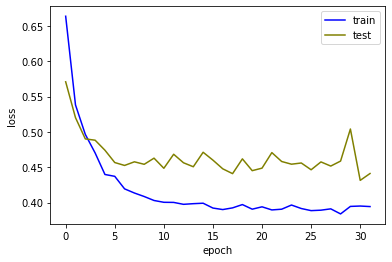

Evaluate on test set
Evaluation accuracy: 0.8899880095923262
Running 2 fold...
Loading datasets...
Done!
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen
Start training...
Epoch 1 training loss:0.6602948848856264
Epoch 1 testing loss:0.5848212735699462
Epoch 2 training loss:0.5328915207639806
Epoch 2 testing loss:0.5374894619614512
Epoch 3 training loss:0.5007526470513001
Epoch 3 testing loss:0.504319850209955
Epoch 4 training loss:0.4678637017865946
Epoch 4 testing loss:0.4852078861302442
Epoch 5 training loss:0.44302217751696726
Epoch 5 testing loss:0.48855440806340167
Epoch 6 training loss:0.4268841752573021
Epoch 6 testing loss:0.4684350242664864
Epoch 7 training loss:0.41773416661005325
Epoch 7 testing loss:0.47179016280729136
Epoch 8 training loss:0.4118243144012463
Epoch 8 testing loss:0.4599472388804138
Epoch 9 training loss:0.4043137011868039
Epoch 9 testing loss:0.48338137777359996
Epoch 10 training loss:0.40076036296639667
E

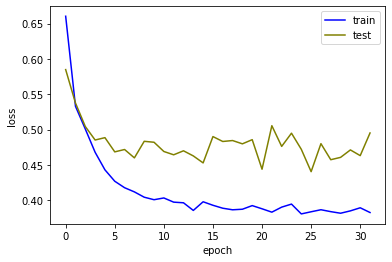

Evaluate on test set
Evaluation accuracy: 0.8591127098321343
Running 3 fold...
Loading datasets...
Done!
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen
Start training...
Epoch 1 training loss:0.651964972200601
Epoch 1 testing loss:0.5807091679211493
Epoch 2 training loss:0.5373469638223501
Epoch 2 testing loss:0.549476425255741
Epoch 3 training loss:0.493138350077208
Epoch 3 testing loss:0.536313350404705
Epoch 4 training loss:0.47032630876980086
Epoch 4 testing loss:0.51059267408139
Epoch 5 training loss:0.44800451256033186
Epoch 5 testing loss:0.4912000902153708
Epoch 6 training loss:0.4300255411244493
Epoch 6 testing loss:0.49685981417740427
Epoch 7 training loss:0.4194836255771735
Epoch 7 testing loss:0.4608824117271392
Epoch 8 training loss:0.40837333927760416
Epoch 8 testing loss:0.48152372621380174
Epoch 9 training loss:0.40227363007268807
Epoch 9 testing loss:0.4677077261758996
Epoch 10 training loss:0.40692219028676646
Epoch

In [ ]:
acc = []

# n-Fold
for i in range((int)(1/params['percent'])):
## SINGLE FOLD
# for i in range(1):
    if os.path.isdir('Dataset'):
        shutil.rmtree('Dataset')

    print(f"Running {i} fold...")
    # Load the dataset and train and test splits
    print("Loading datasets...")

    # Data normalization
    MyTransform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3), # Convert image to grayscale
        transforms.ToTensor(), # Transform from [0,255] uint8 to [0,1] float
        transforms.Normalize([mean, mean, mean], [var, var, var]) # TODO: Normalize to zero mean and unit variance with appropriate parameters
    ])

    # Data path
    DATA_train_path = DataSet('./Dataset/Train', i, randFolders, transform=MyTransform)
    DATA_test_path = DataSet('./Dataset/Test', i, randFolders, transform=MyTransform)

    # DATA_train = datasets.ImageFolder(root=DATA_train_path.ROOT, transform=MyTransform)
    # DATA_test = datasets.ImageFolder(root=DATA_test_path.ROOT, transform=MyTransform)
    DATA_test = DATA_test_path
    DATA_train = DATA_train_path

    print("Done!")

    # Create dataloaders
    # TODO: Experiment with different batch sizes
    trainloader = DataLoader(DATA_train, batch_size=params['batch'], shuffle=True, drop_last=True)
    testloader = DataLoader(DATA_test, batch_size=params['batch'], shuffle=True, drop_last=True)

    device = "cuda" if torch.cuda.is_available() else "cpu" # Configure device
    model = Network().to(device)

    criterion = nn.CrossEntropyLoss() # Specify the loss layer (note: CrossEntropyLoss already includes LogSoftMax())
    # TODO: Modify the line below, experiment with different optimizers and parameters (such as learning rate)
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), momentum=0.9, lr=params['lr'], weight_decay=params['wd']) # Specify optimizer and assign trainable parameters to it, weight_decay is L2 regularization strength (default: lr=1e-2, weight_decay=1e-4)
    num_epochs = params['epochs'] # TODO: Choose an appropriate number of training epochs
    
    def train(model, loader, test, num_epoch = num_epochs): # Train the model
        print("Start training...")
        model.train() # Set the model to training mode
        trainingLoss = []
        testingLoss = []
        for i in range(num_epoch):
            running_loss = []
            test_loss = []
            for batch, label in tqdm(loader, disable=True):
                batch = batch.to(device)
                label = label.to(device)
                optimizer.zero_grad() # Clear gradients from the previous iteration
                pred = model(batch) # This will call Network.forward() that you implement
                loss = criterion(pred, label) # Calculate the loss
                running_loss.append(loss.item())
                loss.backward() # Backprop gradients to all tensors in the network
                optimizer.step() # Update trainable weights
            print("Epoch {} training loss:{}".format(i+1,np.mean(running_loss))) # Print the average loss for this epoch
            with torch.no_grad():
                for batch, label in tqdm(test, disable=True):
                    batch = batch.to(device)
                    label = label.to(device)
                    optimizer.zero_grad() # Clear gradients from the previous iteration
                    pred = model(batch) # This will call Network.forward() that you implement
                    loss = criterion(pred, label) # Calculate the loss
                    test_loss.append(loss.item())
            print("Epoch {} testing loss:{}".format(i+1,np.mean(test_loss))) # Print the average loss for this epoch
            trainingLoss.append(np.mean(running_loss))
            testingLoss.append(np.mean(test_loss))
        print("Done!")
        print(f"Average Testing Loss: {np.mean(testingLoss)}")
        print(f"Average Training Loss: {np.mean(trainingLoss)}")
        plt.plot(trainingLoss, color='blue', label="train")
        plt.plot(testingLoss, color='olive', label="test")
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

    def evaluate(model, loader): # Evaluate accuracy on validation / test set
        model.eval() # Set the model to evaluation mode
        correct = 0
        with torch.no_grad(): # Do not calculate grident to speed up computation
            for batch, label in tqdm(loader, disable=True):
                batch = batch.to(device)
                label = label.to(device)
                pred = model(batch)
                correct += (torch.argmax(pred,dim=1)==label).sum().item()
        acc = correct/len(loader.dataset)
        print("Evaluation accuracy: {}".format(acc))
        return acc
      
    train(model, trainloader, testloader, num_epochs)
    print("Evaluate on test set")
    acc.append(evaluate(model, testloader))

print(f"Average Accuracy: {np.mean(acc)}")